In [110]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from copy import deepcopy

In [111]:
def find_new_threshold(old_threshold, histogram):
    """ This function will find the new threshold 
    in order to divide the histogram into two groups """
    
    sum_of_first_group = 0
    weighted_sum_of_first_group = 0
    sum_of_second_group = 0
    weighted_sum_of_second_group = 0
    i = 0
    for histogram_value in histogram:
        histogram_value = int(histogram_value)
        if i < old_threshold:
            weighted_sum_of_first_group += histogram_value * i
            sum_of_first_group += histogram_value
        elif i >= old_threshold:
            weighted_sum_of_second_group += histogram_value * i
            sum_of_second_group += histogram_value
        i += 1

    mean_of_first_group = weighted_sum_of_first_group / sum_of_first_group
    mean_of_second_group = weighted_sum_of_second_group / sum_of_second_group

    new_threshold = (mean_of_first_group + mean_of_second_group) / 2
    return new_threshold

In [112]:
def find_first_threshold(histogram):
    """ This function will find the first threshold
    by using weighted average, more pixels on a histogram value
    gives more weight to that value"""
    
    i = 0
    weighted_sum_of_histograms = 0
    sum_of_histogram_values = 0
    for histogram_value in histogram:
        histogram_value = int(histogram_value)
        weighted_sum_of_histograms += histogram_value * i
        sum_of_histogram_values += histogram_value
        i += 1
        # print(histogram_value)

    threshold = weighted_sum_of_histograms / sum_of_histogram_values
    return threshold

In [113]:
def is_new_threshold_converged(old_threshold, new_threshold):
  """ To find where to stop while iterating 
  using int() will truncate the thresholds """

  if int(old_threshold) == int(new_threshold):
      return True
  return False

This is the original sudoku image

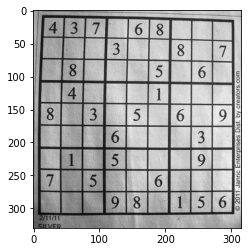

In [114]:
img = imread(
    "https://raw.githubusercontent.com/muthuspark/ml_research/master/resources/sudoku4.jpg")

# convert the image to grayscale
gray_img = rgb2gray(img)
gray_img *= 255
gray_img = gray_img.astype(np.uint8)
# now our image is in [0-255] range
plt.imshow(gray_img, cmap="gray")
plt.show()

Histogram of the original image

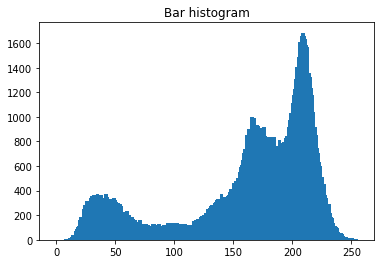

In [115]:
hist = cv2.calcHist([gray_img], [0], None, [256], [0, 255])
intensity_values = np.array([x for x in range(hist.shape[0])])
plt.bar(intensity_values, hist[:, 0], width=3)
plt.title("Bar histogram")
plt.show()

This code piece will iterate until the newly found threshold is nearly equal to the old one

In [116]:
first_threshold = find_first_threshold(hist)
print(f"First threshold found: {first_threshold}")
new_threshold = find_new_threshold(first_threshold, hist)
print(f"New threshold found: {new_threshold}")
old_threshold = first_threshold
while not is_new_threshold_converged(old_threshold, new_threshold):
    old_threshold = new_threshold
    # print(f"Old threshold for the image is: {old_threshold}")
    new_threshold = find_new_threshold(old_threshold, hist)
    # print(f"New threshold for the image is: {new_threshold}")  # I used these prints while testing

print(f"Final threshold calculated after convergence: {new_threshold}")

First threshold found: 161.9524827863979
New threshold found: 146.44250897571717
Final threshold calculated after convergence: 124.4163381850751


After finding the final threshold, we set the values higher than the threshold as white, and the others as black to segment the image

In [117]:
thresholded_image = deepcopy(gray_img)
row_index = 0
for row in gray_img:
    column_index = 0
    for pixel in row:
        if pixel > new_threshold:
            thresholded_image[row_index][column_index] = 255
        else:
            thresholded_image[row_index][column_index] = 0
        column_index += 1
    row_index += 1

This is the result of the custom implemented global thresholding

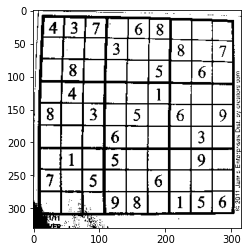

In [118]:
plt.imshow(thresholded_image, cmap='gray')
plt.show()

Side by side, the library implementation of Otsu and our implementation look like this

Threshold found by library implementation of Otsu: 124


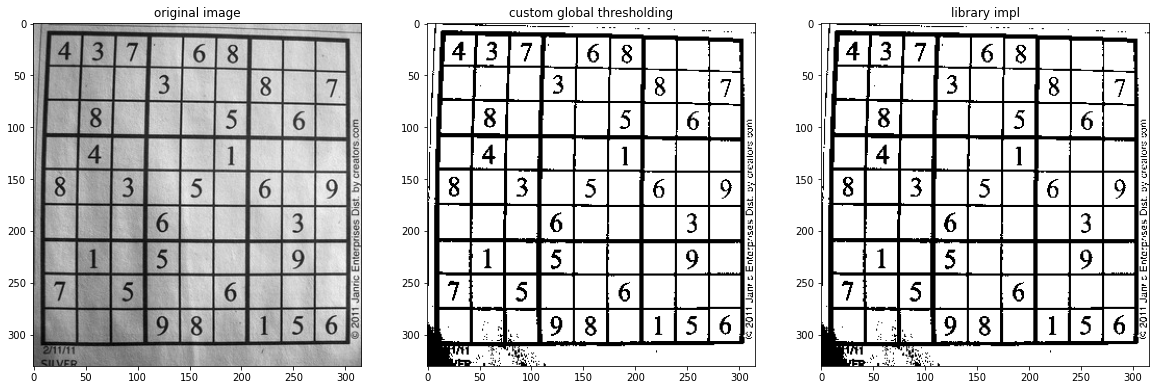

In [119]:
image_for_otsu_to_threshold = deepcopy(gray_img)
# thresholding the image using the skimage library implementation
threshold_s = threshold_otsu(image_for_otsu_to_threshold)
bin_img_from_lib = gray_img > threshold_s

print(f"Threshold found by library implementation of Otsu: {threshold_s}")

fig, ax = plt.subplots(ncols=3, figsize=(20, 20))
ax[0].set_title("original image")
ax[0].imshow(gray_img, cmap="gray")

ax[1].set_title("custom global thresholding")
ax[1].imshow(thresholded_image, cmap="gray")

ax[2].set_title("library impl")
ax[2].imshow(bin_img_from_lib, cmap="gray")

plt.show()

The two images are exactly the same. From the variable list on the left it can be seen that our custom implementation has found the threshold to be 124.4163... (new_threshold variable) and library implementation of Otsu calculates the threshold as 124.